Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [54]:
from random import random, seed
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import math, time
from itertools import accumulate
from icecream import ic
import random

In [55]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2


np.random.seed(23)
random.seed(23)
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [56]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

## Functions and Variables

In [57]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

In [58]:
def rounding(numero):
    if numero == 0:
        return 1
    else:
        return math.ceil(numero)


def dynamic_tweak(solution: np.ndarray, it) -> np.ndarray:  
    new_sol = solution.copy()
    
    n_change = max(1, int((n_to_change-it)/2)-it)  #decreasing function as it(current iteration) increases
    #ic(n_change)
    
    # Select some integeres
    indices_to_change = np.random.choice(len(solution), size=n_change, replace=False)

    for i in indices_to_change:
        new_sol[i] = not new_sol[i]
        
    return new_sol


def fitness(solution: np.ndarray):
    fitness = -cost(solution) 
    return fitness

In [59]:
num = UNIVERSE_SIZE/NUM_SETS
n_to_change = rounding((UNIVERSE_SIZE/num)*DENSITY)   #Initial number of changes  

if UNIVERSE_SIZE <= 100:
    n_inner_it = 200
    
if UNIVERSE_SIZE <= 1_000:
    n_inner_it = 500
    
elif UNIVERSE_SIZE <= 10_000:
    n_inner_it = 1_000
    
else:
    n_inner_it = 4_000   
    n_to_change = n_to_change*5      # Special case as the UNIVERSE_SIZE is very big
       
    
ic(n_to_change)    
ic(n_inner_it)

ic| n_to_change: 200
ic| n_inner_it: 1000


1000

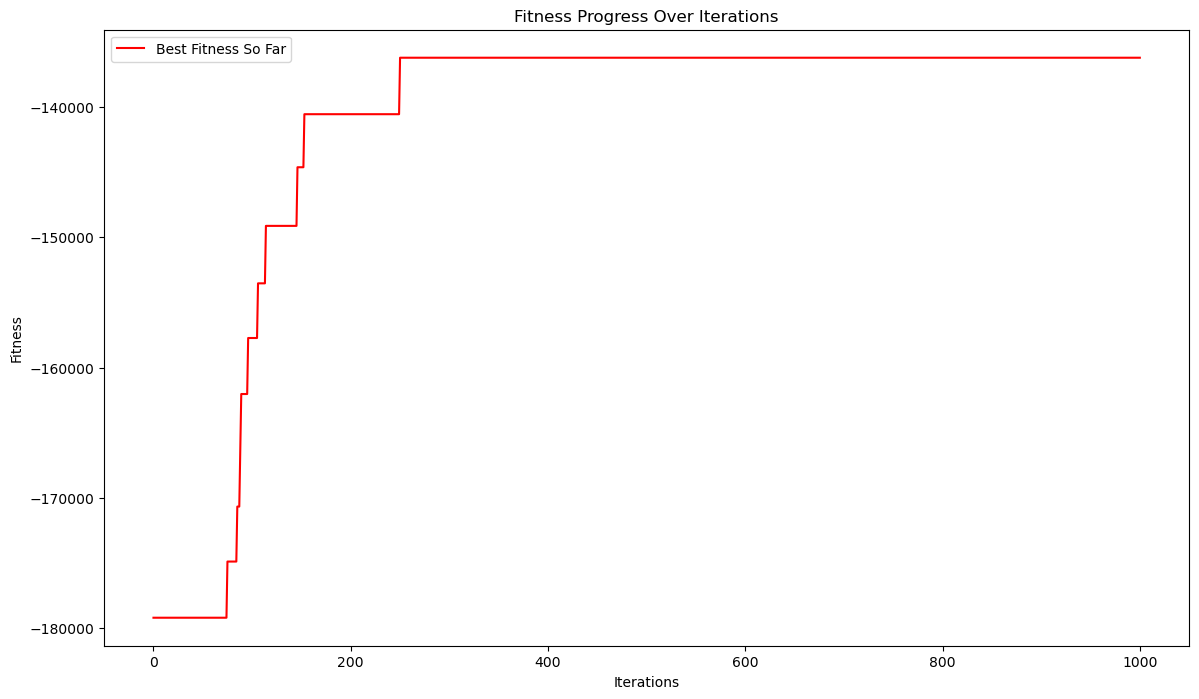

ic| f"Final fitness: {solution_fitness}": 'Final fitness: -136243.8654934711'
ic| f"Computation time: {elapsed_time:.2f} seconds": 'Computation time: 0.46 seconds'
ic| f"Solution cost: {cost(solution)}": 'Solution cost: 136243.8654934711'


'Solution cost: 136243.8654934711'

In [60]:
history =[]

start_time = time.time()
solution = np.full(NUM_SETS, False)    ### Idea from G.P. ###
k=1
while not valid(solution):
    solution = np.full(NUM_SETS, False)
    indexes = np.random.randint(0, NUM_SETS, size=k)
    solution[indexes] = True 
    k = k+1


solution_fitness = fitness(solution) 
history.append(solution_fitness)
    
for steps in range(n_inner_it):
    #ic(steps)
    best_tweak = solution
    
    if not valid(best_tweak):   #check
        ic(valid(best_tweak))
        
    best_tweak_fitness = fitness(best_tweak)
                
    for tw in range(5):   # Best improvements
        new_solution = dynamic_tweak(best_tweak, steps)
        new_solution_fitness = fitness(new_solution)
        
        if new_solution_fitness > best_tweak_fitness and valid(new_solution):
            best_tweak = new_solution
            best_tweak_fitness = new_solution_fitness
            
    # Update the solution if the best_tweak is better
    if best_tweak_fitness > solution_fitness and valid(best_tweak):
        solution = best_tweak
        solution_fitness = best_tweak_fitness
            
    history.append(solution_fitness)
    
    
end_time = time.time()
elapsed_time = end_time - start_time  




# PLOT
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
    label="Best Fitness So Far"
)
#plt.scatter(range(len(history)), history, marker=".", color="blue", label="Fitness Over Time")
plt.title("Fitness Progress Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.legend()
plt.show()

ic(f"Final fitness: {solution_fitness}")
ic(f"Computation time: {elapsed_time:.2f} seconds")
ic(f"Solution cost: {cost(solution)}")

### Small improvements ###

This improvements does not work for the 4th, 5th, 6th case as the algorithm becomes too slow.

In [61]:
initial_temperature = n_inner_it/5
cooling_rate = 0.98

ic(initial_temperature)

ic| initial_temperature: 200.0


200.0

ic| fitness(solution): -175317.53487711458


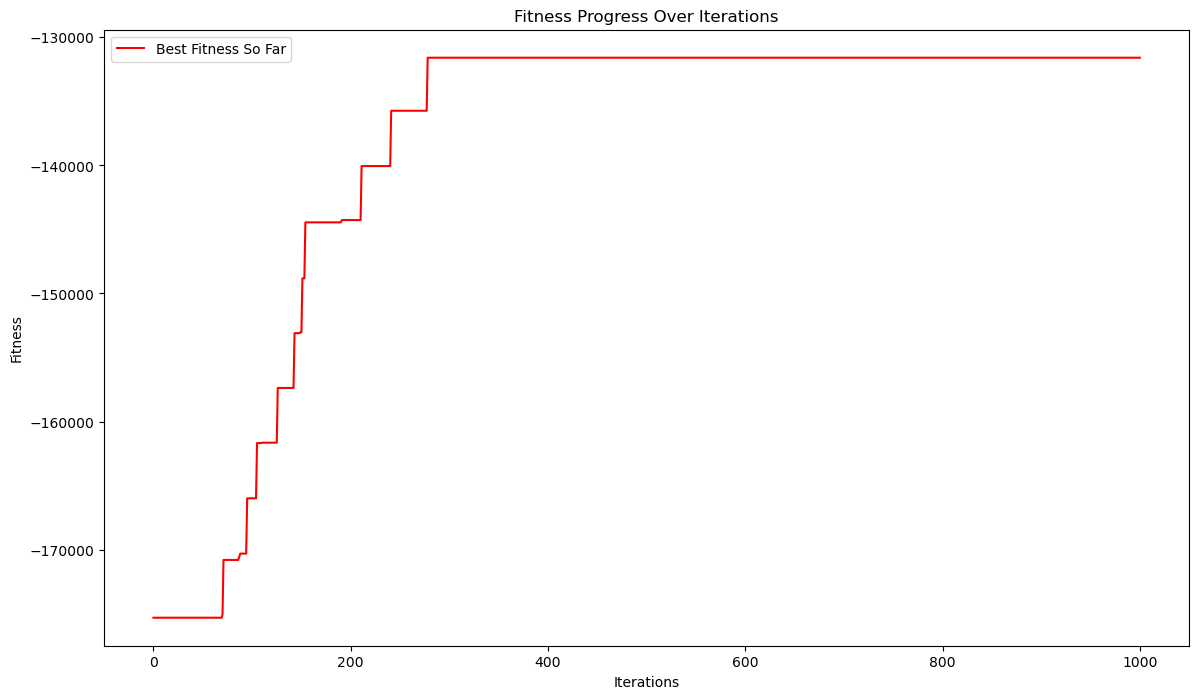

ic| f"Final fitness: {solution_fitness}": 'Final fitness: -131592.85612894854'
ic| f"Computation time: {elapsed_time:.2f} seconds": 'Computation time: 2.03 seconds'
ic| f"Solution cost: {cost(solution)}": 'Solution cost: 131592.85612894854'


'Solution cost: 131592.85612894854'

In [62]:
### WITH intermediate HILL CLIMBING and SIMUALTED ANNEALING ###

def intermediate_hill_climb(solution: np.ndarray, it:int) -> np.ndarray:
    num_flips = max(1, int((((n_to_change-it)/2)-2*it)/5))
    current_solution = solution.copy()
    current_fitness = fitness(current_solution)
    indices_to_flip = np.random.choice(len(solution), size=num_flips, replace=False)
    
    for i in indices_to_flip:    #random selected indices
        new_solution = current_solution.copy()
        new_solution[i] = not current_solution[i]   
        if valid(new_solution):    #First improvement
            new_fitness = fitness(new_solution)
            if new_fitness > current_fitness:
                return new_solution
   
    return current_solution    # If no improvement was found, return


def simulated_annealing_acceptance(new_fitness, current_fitness, temperature):
    if new_fitness > current_fitness:
        return True 
    else:
        acceptance_prob = np.exp((new_fitness - current_fitness) / temperature)
        return np.random.rand() < acceptance_prob  # Accept with this probability

    
history =[]

start_time = time.time()

solution = np.full(NUM_SETS, False)    ### Idea from G.P. ###
k=1
while not valid(solution):
    solution = np.full(NUM_SETS, False)
    indexes = np.random.randint(0, NUM_SETS, size=k)
    solution[indexes] = True 
    k = k+1

ic(fitness(solution))

solution_fitness = fitness(solution) 
history.append(solution_fitness)    

    
for steps in range(n_inner_it):
    #ic(steps)
    
    temperature = initial_temperature * (cooling_rate ** steps)
        
    best_tweak = solution
    best_tweak_fitness = fitness(best_tweak)
                
    for tw in range(5):  # Trying different tweaks
        new_solution = dynamic_tweak(best_tweak, steps)
        new_solution_fitness = fitness(new_solution)
        
        # Apply hill-climbing to locally refine the new solution
        refined_solution = intermediate_hill_climb(new_solution, steps)
        refined_fitness = fitness(refined_solution)
        
        if refined_fitness > new_solution_fitness and valid (refined_solution):
            new_solution = refined_solution
            new_solution_fitness = refined_fitness   
        
        # Simulated annealing
        if simulated_annealing_acceptance(new_solution_fitness, best_tweak_fitness, temperature) and valid(new_solution):
            best_tweak = new_solution
            best_tweak_fitness = new_solution_fitness
    
    # Simulated annealing
    if simulated_annealing_acceptance(best_tweak_fitness, solution_fitness, temperature) and valid(best_tweak):
        solution = best_tweak
        solution_fitness = best_tweak_fitness
            
    history.append(solution_fitness)
    
end_time = time.time()
elapsed_time = end_time - start_time  

  
    
# PLOT
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
    label="Best Fitness So Far"
)
#plt.scatter(range(len(history)), history, marker=".", color="blue", label="Fitness Over Time")
plt.title("Fitness Progress Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.legend()
plt.show()

ic(f"Final fitness: {solution_fitness}")
ic(f"Computation time: {elapsed_time:.2f} seconds")
ic(f"Solution cost: {cost(solution)}")

### Results
1,2,3 obtained with the improved strategy <br>
4,5,6 obtained with the simplest strategy

1)
UNIVERSE_SIZE = 100 <br>
NUM_SETS = 10 <br>
DENSITY = 0.2 <br>
Solution cost: 286.43775977201597 <br>
Computation time: 0.12 seconds <br>

2)
UNIVERSE_SIZE = 1_000 <br>
NUM_SETS = 100 <br>
DENSITY = 0.2 <br>
Solution cost: 6347.784660663539 <br>
Computation time: 0.39 seconds <br>

3)
UNIVERSE_SIZE = 10_000 <br>
NUM_SETS = 1_000 <br>
DENSITY = 0.2 <br>
Solution cost: 131592.85612894854 <br>
Computation time: 2.23 seconds <br>

4)
UNIVERSE_SIZE = 100_000 <br>
NUM_SETS = 10_000 <br>
DENSITY = 0.1 <br>
Solution cost: 2009895.2513356414 <br>
Computation time: 41.54 seconds <br>

5)
UNIVERSE_SIZE = 100_000 <br>
NUM_SETS = 10_000 <br>
DENSITY = 0.2 <br>
Solution cost: 2319998.564787915 <br>
Computation time: 41.41 seconds <br>

6)
UNIVERSE_SIZE = 100_000 <br>
NUM_SETS = 10_000 <br>
DENSITY = 0.3 <br>
Solution cost: 2610023.2840255746 <br>
Computation time: 57.14 seconds